# Machine learning pipeline for modelling fraction of precipitation in different intensity bands

This notebook is designed to be run in AzureML 

### Import relevant libraries

In [3]:
import pathlib
import os
import datetime
import json

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# %load_ext tensorboard

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [7]:
import prd_pipeline

In [8]:
pathlib.Path.cwd().parent

PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/prd_fractional')

Set up MLops for experiment tracking in AzureML

In [ ]:
import mlflow
mlflow.tensorflow.autolog()

In [10]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [ ]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

### Load and preprocess data

In [14]:
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [20]:
target_parameter = [
    'radar_fraction_in_band_instant_0.25',
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction'] #'air_pressure','cloud_volume_fraction',
single_lvl_features = [] #['surface_altitude']#,'air_pressure_at_sea_level','cloud_area_fraction']#'thickness_of_rainfall_amount']#] 

In [24]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [2]:
load_all = False

In [15]:
if load_all:
    prd_azml_dataset_name = 'prd_merged_all_events_files'
else:
    prd_azml_dataset_name = 'prd_merged_202110_nswws_amber_oct_files'


In [17]:
prd_azml_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_azml_dataset_name)

In [ ]:
with prd_azml_dataset.mount() as prd_mount:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(prd_mount.mount_point).rglob('*csv') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])

Volume mount is not enabled. 
Falling back to dataflow mount.
loading all data


<b>TO DO:</b> Add MOGREPS-G probability in intensity bands calculation 

### Calculate u and v wind fields and add column to dataset <i>- to be moved into data prep </i>

Adding columns with u and v wind fields

In [21]:
import math

wdir_columns = prd_pipeline.get_profile_columns(['wind_from_direction'], merged_df.columns)
ws_columns = prd_pipeline.get_profile_columns(['wind_speed'], merged_df.columns)

for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.sin(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']
    merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.cos(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']

5.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


10.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


20.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


30.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


50.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


75.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


100.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


150.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


200.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


250.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


300.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


400.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


600.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


700.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


800.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1250.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


1750.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2250.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


2750.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3250.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


3750.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


4000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


4500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


5000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


5500.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


6000.0


/tmp/ipykernel_9157/259804250.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
/tmp/ipykernel_9157/259804250.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(


To check the u and v wind conversion, we convert back from u and v wind fields to wind speed and direction and compare this to wind speed and direction in the dataset. This test currently fails as there are a few data points with wind speeds of zero. May be worth some investigation into whether these zero are spurious or not, but perhaps easiest at this stage to filter out zero values. 

In [22]:
# test for u and v wind conversion
for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    print(merged_df[(merged_df[f'wind_from_direction_{height_level}'] != np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4))][[f'wind_from_direction_{height_level}', f'wind_speed_{height_level}']])
    merged_df = merged_df[merged_df[ws] != 0]
    
    assert (merged_df[f'wind_speed_{height_level}'] == np.round(np.sqrt(merged_df[f'u_wind_{height_level}']**2 + merged_df[f'v_wind_{height_level}']**2),4)).all()
    assert (merged_df[f'wind_from_direction_{height_level}'] == np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4)).all()

5.0
Empty DataFrame
Columns: [wind_from_direction_5.0, wind_speed_5.0]
Index: []
10.0
Empty DataFrame
Columns: [wind_from_direction_10.0, wind_speed_10.0]
Index: []
20.0
        wind_from_direction_20.0  wind_speed_20.0
15384                   120.9375              0.0
46116                   167.9375              0.0
47130                   240.5625              0.0
236583                  186.9375              0.0
284608                  244.8125              0.0
30.0
        wind_from_direction_30.0  wind_speed_30.0
20839                    45.0000              0.0
24323                   135.0000              0.0
24324                   153.4375              0.0
24870                   243.4375              0.0
206348                  135.0000              0.0
16801                    60.8125              0.0
44612                   312.2500              0.0
44709                   331.3125              0.0
128175                   90.0000              0.0
154882                  2

### Data pre-processing

Split train, test and validate datasets

In [25]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

target has dims: 5
dropping smallest bin: radar_fraction_in_band_instant_0.0
getting profile columns
{'nprof_features': 4, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


In [17]:
data_splits['X_train'].shape

(792954, 33, 4)

### Plot pie charts of average fractions in bands

Make a copy of the training dataset and add a column which contains the label for the intensity band with the highest fraction

In [27]:
tmp = data_splits['y_train'].copy().reset_index(drop=True)
tmp['max_bin'] = tmp.idxmax(axis=1)
tmp[tmp['max_bin']==feature_dict['target'][-1]]

,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,max_bin
37242,0.0,0.028947,0.339474,0.634211,radar_fraction_in_band_instant_10.0
37243,0.0,0.028947,0.339474,0.634211,radar_fraction_in_band_instant_10.0
37244,0.0,0.028947,0.339474,0.634211,radar_fraction_in_band_instant_10.0
37245,0.0,0.028947,0.339474,0.634211,radar_fraction_in_band_instant_10.0
37246,0.0,0.028947,0.339474,0.634211,radar_fraction_in_band_instant_10.0
...,...,...,...,...,...
455563,0.0,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
455564,0.0,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
455565,0.0,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0
455566,0.0,0.207143,0.388095,0.409524,radar_fraction_in_band_instant_10.0


Plot a pie chart of counts of the different intensity bands having highest fraction

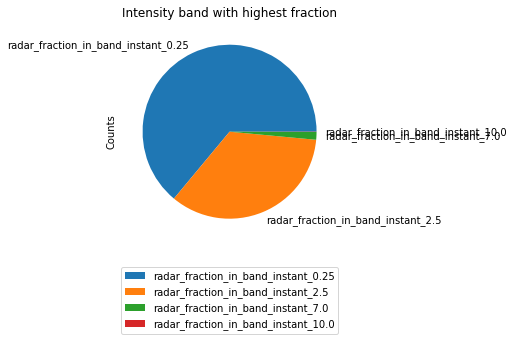

In [28]:
avg_df = pd.DataFrame({'Counts': tmp['max_bin'].value_counts()})
avg_df.plot.pie(subplots=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.title('Intensity band with highest fraction')
plt.show()

In [29]:
def pie_chart_mean_fractions_in_bands(df, title):
    """Calculates the average values of a pandas series provided and produces a pie chart"""
    avg_df = pd.DataFrame({'Average': df.mean()})
    avg_df.plot.pie(subplots=True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.title(title)
    plt.show()

Produce pie chart for the average fraction in each intensity band for the train, test and validate datasets

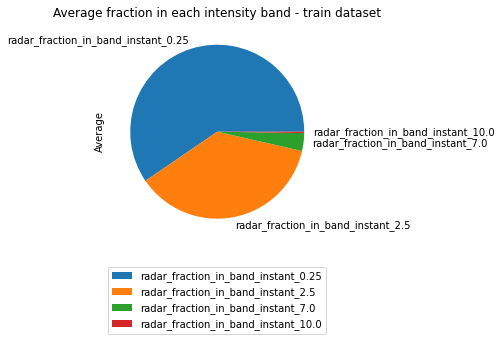

In [30]:
pie_chart_mean_fractions_in_bands(data_splits['y_train'], title='Average fraction in each intensity band - train dataset')

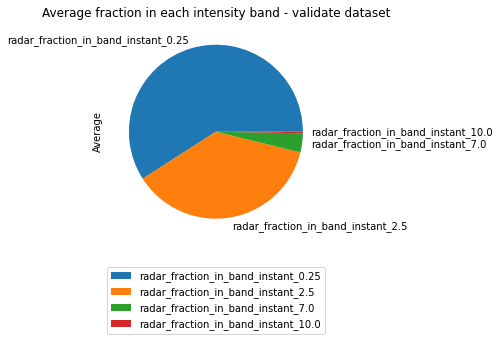

In [31]:
pie_chart_mean_fractions_in_bands(data_splits['y_val'], title='Average fraction in each intensity band - validate dataset')

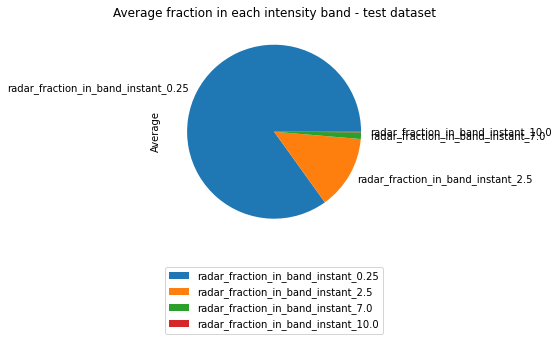

In [32]:
pie_chart_mean_fractions_in_bands(df_test[target_parameter], title='Average fraction in each intensity band - test dataset')

<AxesSubplot:>

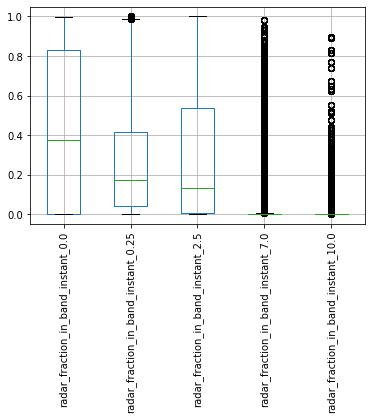

In [24]:
data_splits['y_train'].boxplot(rot=90)

<AxesSubplot:>

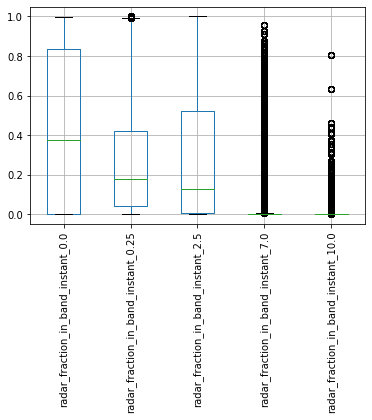

In [25]:
data_splits['y_val'].boxplot(rot=90)

<AxesSubplot:>

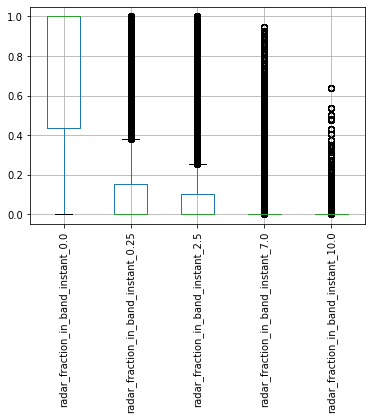

In [26]:
df_test[target_parameter].boxplot(rot=90)

For each intensity band, select a subset which contains datapoint where the highest fraction falls into that intensity band, then produce the pie chart showing this average fraction in each intensity band. This allows us to see whether on average when a band has highest fraction whether it is marginally highest or is much higher than fractions of other bands.

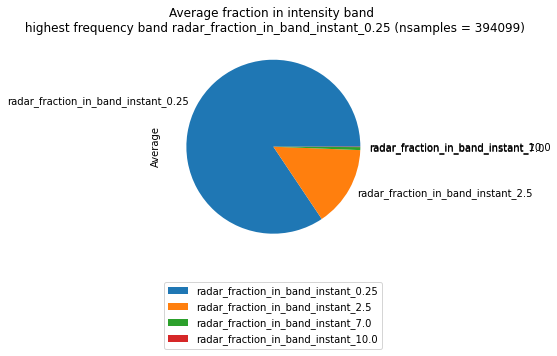

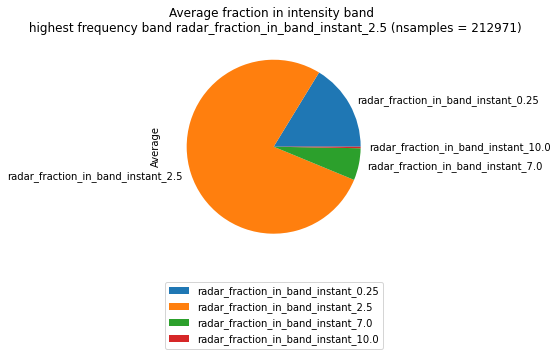

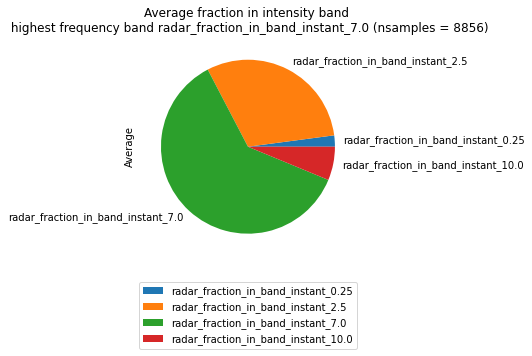

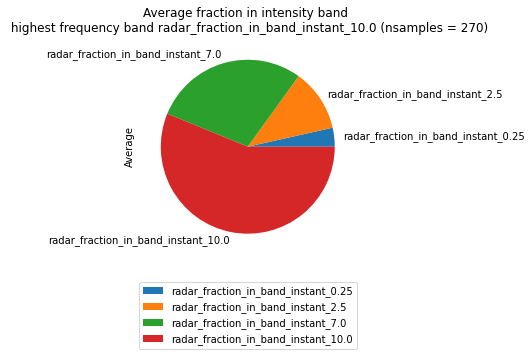

In [ ]:
tmp = tmp.reset_index(drop=True)
for col in tmp.columns[:-1]:
    subset = tmp[tmp['max_bin']==col]
    pie_chart_mean_fractions_in_bands(subset, title=f'Average fraction in intensity band \n highest frequency band {col} (nsamples = {len(subset)})')
    plt.show()

### Class imbalance

Calculate weights to input when fitting model, which is used for weighting the loss function in the model training.

In [28]:
tmp = data_splits['y_train'].copy()
tmp['max_bin'] = tmp.idxmax(axis=1)

In [29]:
tmp['max_bin'].value_counts()

radar_fraction_in_band_instant_0.0     377088
radar_fraction_in_band_instant_2.5     233039
radar_fraction_in_band_instant_0.25    173449
radar_fraction_in_band_instant_7.0       9000
radar_fraction_in_band_instant_10.0       378
Name: max_bin, dtype: int64

In [30]:
data_splits['y_train'][data_splits['y_train']['radar_fraction_in_band_instant_7.0']>0.1]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
4032,0.228571,0.37381,0.219048,0.135714,0.047619
4033,0.228571,0.37381,0.219048,0.135714,0.047619
4034,0.228571,0.37381,0.219048,0.135714,0.047619
4035,0.228571,0.37381,0.219048,0.135714,0.047619
4036,0.228571,0.37381,0.219048,0.135714,0.047619
...,...,...,...,...,...
1053676,0.077694,0.20802,0.526316,0.205514,0.000000
1053677,0.077694,0.20802,0.526316,0.205514,0.000000
1053678,0.077694,0.20802,0.526316,0.205514,0.000000
1053679,0.077694,0.20802,0.526316,0.205514,0.000000


In [31]:
data_splits['y_train'].mean()

radar_fraction_in_band_instant_0.0     0.425700
radar_fraction_in_band_instant_0.25    0.263673
radar_fraction_in_band_instant_2.5     0.292225
radar_fraction_in_band_instant_7.0     0.026192
radar_fraction_in_band_instant_10.0    0.002161
dtype: float64

In [32]:
# weights = 1 / (tmp['max_bin'].value_counts() / tmp.shape[0]) / 4
weights = 1 / data_splits['y_train'].mean() / 10
weights = weights.reset_index(drop=True).to_dict()
weights

{0: 0.2349074125650547,
 1: 0.37925741669417345,
 2: 0.34220157084621283,
 3: 3.817955774525788,
 4: 46.2779252172111}

Resample data to create more uniform distribution within the training data

In [33]:
# nsamples = len(tmp)//len(tmp.columns)
# print('n samples =', nsamples)

# y_train = pd.DataFrame()

# tmp = tmp.reset_index(drop=True)

# for col in tmp.columns[0:-1]:
#     print(col)
#     ids = tmp[tmp['max_bin']==col].index
#     print(ids.shape)
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, tmp.loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns
# plt.plot(data_splits['y_train'].sum(axis=0), label='original data')
# plt.plot(y_train[cols].sum(axis=0), label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [34]:
exp_name='prd_fraction_models_mlflow'
exp1 = mlflow.create_experiment(exp_name)
exp1

'27014deb-848c-4241-966e-55b80a0c8ed4'

In [35]:
exp1 = mlflow.get_experiment(exp1)
exp1

<Experiment: artifact_location='', experiment_id='27014deb-848c-4241-966e-55b80a0c8ed4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

In [36]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64, 
    'class_weights': weights
}

In [37]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict)

2022-08-31 12:45:41.621305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-31 12:45:42.182521: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-31 12:45:42.182595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prd-ml-fractions): /proc/driver/nvidia/version does not exist
2022-08-31 12:45:42.185161: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-31 12:45:42.193615: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2593905000 Hz
2022-08-31 12:45:42.195604: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff590000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
profile_input (InputLayer)      [(None, 33, 4)]      0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 35, 4)        0           profile_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 33, 32)       384         zero_padding1d[0][0]             
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 35, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

2022-08-31 12:45:42.495052: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


Epoch 1/10
  29/9629 [..............................] - ETA: 52s - loss: 0.4223 - accuracy: 0.6719

2022-08-31 12:45:45.613965: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-08-31 12:45:45.623002: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: /tmp/tmp23rv3id0/train/plugins/profile/2022_08_31_12_45_45
2022-08-31 12:45:45.623748: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to /tmp/tmp23rv3id0/train/plugins/profile/2022_08_31_12_45_45/prd-ml-fractions.trace.json.gz
2022-08-31 12:45:45.624408: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.021 ms

2022-08-31 12:45:45.625671: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: /tmp/tmp23rv3id0/train/plugins/profile/2022_08_31_12_45_45Dumped tool data for overview_page.pb to /tmp/tmp23rv3id0/train/plugins/profile/2022_08_31_12_45_45/prd-ml-fractions.overview_page.pb
Dumped tool data for input_pipeline.pb to /tmp/tmp23rv3id0/train/plugins/profi

9629/9629 [==============================] - 47s 5ms/step - loss: 0.2853 - accuracy: 0.7539 - val_loss: 0.2740 - val_accuracy: 0.7591
Epoch 2/10
9629/9629 [==============================] - 46s 5ms/step - loss: 0.2513 - accuracy: 0.7779 - val_loss: 0.2604 - val_accuracy: 0.7678
Epoch 3/10
9629/9629 [==============================] - 46s 5ms/step - loss: 0.2369 - accuracy: 0.7888 - val_loss: 0.2552 - val_accuracy: 0.7691
Epoch 4/10
9629/9629 [==============================] - 47s 5ms/step - loss: 0.2283 - accuracy: 0.7951 - val_loss: 0.2534 - val_accuracy: 0.7732
Epoch 5/10
9629/9629 [==============================] - 46s 5ms/step - loss: 0.2217 - accuracy: 0.7992 - val_loss: 0.2515 - val_accuracy: 0.7724
Epoch 6/10
9629/9629 [==============================] - 47s 5ms/step - loss: 0.2167 - accuracy: 0.8032 - val_loss: 0.2457 - val_accuracy: 0.7779
Epoch 7/10
9629/9629 [==============================] - 46s 5ms/step - loss: 0.2127 - accuracy: 0.8064 - val_loss: 0.2425 - val_accuracy: 0.7

Using TensorFlow backend.
2022/08/31 12:53:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: module 'tensorflow.compat.v2' has no attribute '__internal__'


### Feature importance

Here we calculate the Breiman permutation importance for each of the model input features. This allows us to assess how much information each input feature is contributing to the resulting predictions from the ML model. 

 - At each step, only one predictor is permuted (randomized)
 - The amount by which the loss function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the loss function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the loss function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the loss function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [ ]:
feature_names = feature_dict['profile'] + feature_dict['single_level']

In [ ]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 5

original_metric = history.history['val_loss'][-1]

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        if data_dims_dict['nsinglvl_features'] > 0:
            X_val_permute = [data_splits['X_val'][0].copy(), data_splits['X_val'][1].copy()]
            if feature in feature_dict['single_level']:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = data_splits['X_val'].copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        
        permuted_metric = tf.keras.metrics.KLDivergence()
        permuted_metric.update_state(data_splits['y_val'], y_pred)
        permuted_metric = permuted_metric.result().numpy()
        
        permutation_importance[feature].append(permuted_metric - original_metric)

permuting feature: air_temperature
8260/8260 [==============================] - 15s 2ms/step
permuting feature: relative_humidity
8260/8260 [==============================] - 15s 2ms/step
permuting feature: wind_speed
8260/8260 [==============================] - 15s 2ms/step
permuting feature: wind_from_direction
8260/8260 [==============================] - 15s 2ms/step


In [40]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.38027064204216005, 'relative_humidity': 0.35603700280189515, 'u_wind': 0.30232704281806944, 'v_wind': 0.33314633965492246}


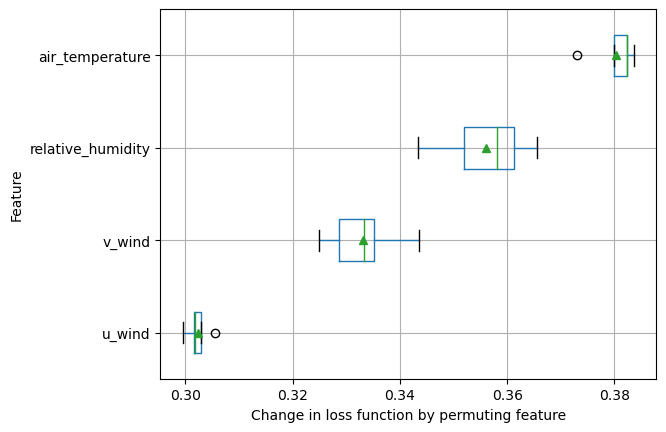

In [41]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

In [ ]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.25699364244937895, 'relative_humidity': 0.22774945795536042, 'u_wind': 0.2694969803094864, 'v_wind': 0.29922627508640287}


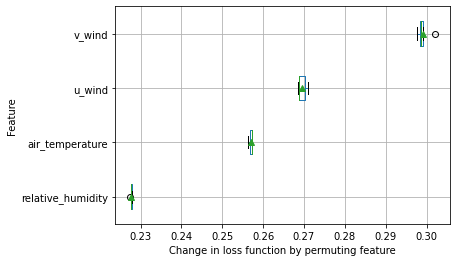

In [ ]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

### Model evaluation

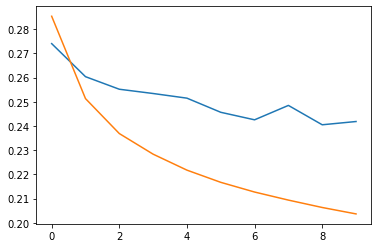

In [ ]:
plt.plot(range(10),history.history['val_loss'])
plt.plot(range(10), history.history['loss'])

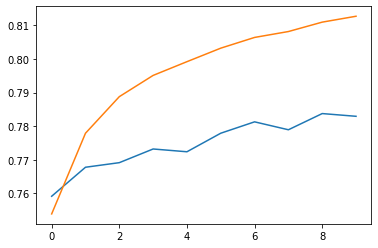

In [ ]:
plt.plot(range(10), history.history['val_accuracy'])
plt.plot(range(10), history.history['accuracy'])

In [ ]:
y_pred = model.predict(data_splits['X_val'])

8260/8260 [==============================] - 15s 2ms/step


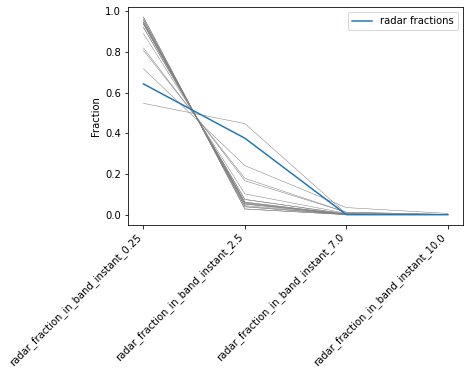

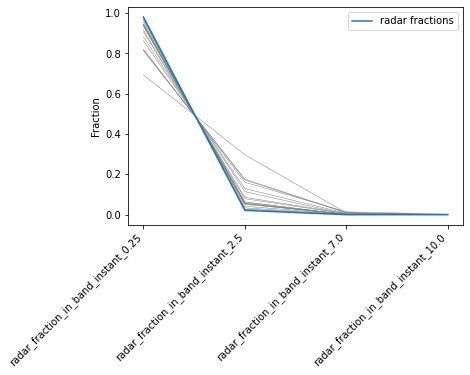

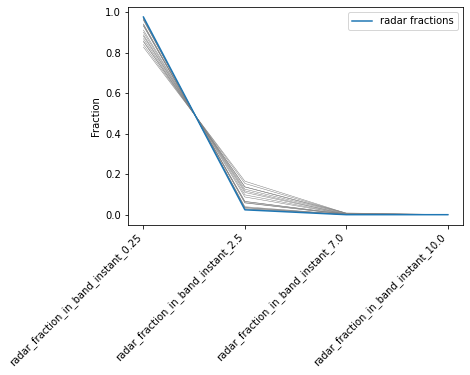

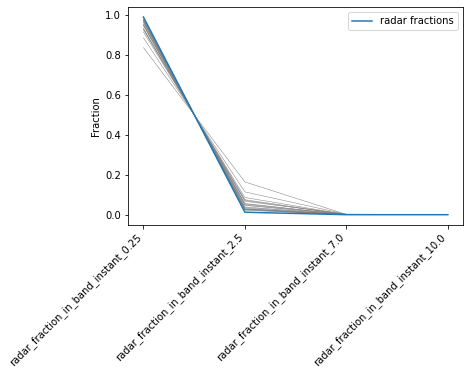

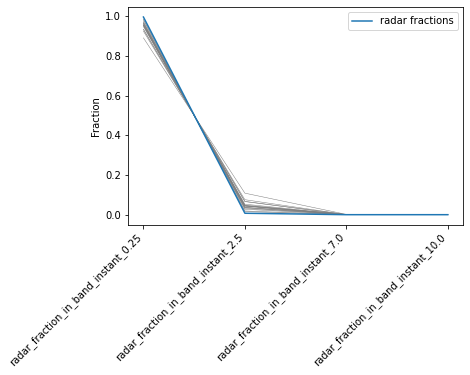

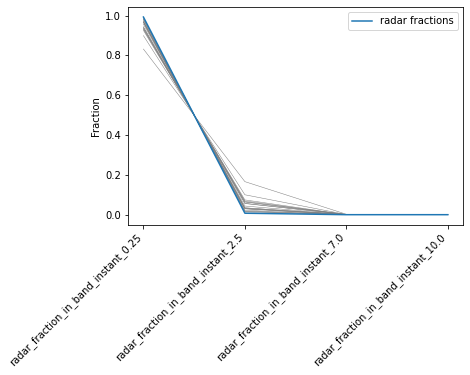

In [ ]:
for loc in np.arange(0,91,18):
    for member in np.arange(18):
        plt.plot(y_pred[loc+member], lw=0.5, color='grey')
    plt.plot(data_splits['y_val'].iloc[loc+member], label='radar fractions')
    plt.ylabel('Fraction')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

/tmp/ipykernel_17650/1164487161.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, target_parameter)


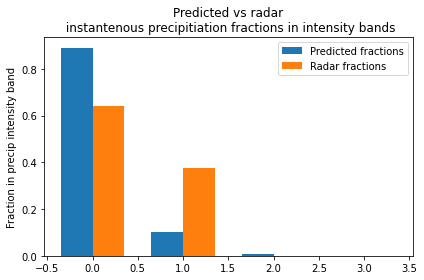

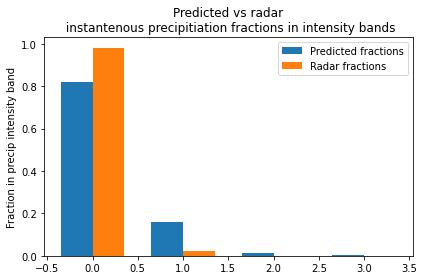

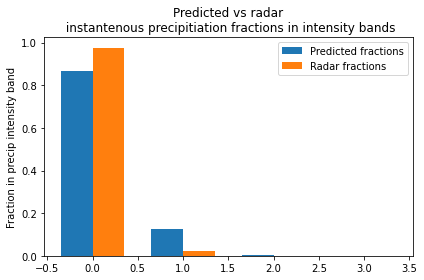

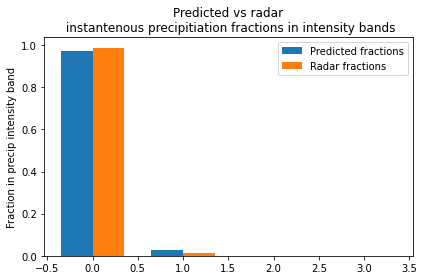

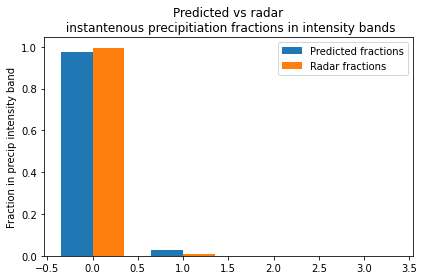

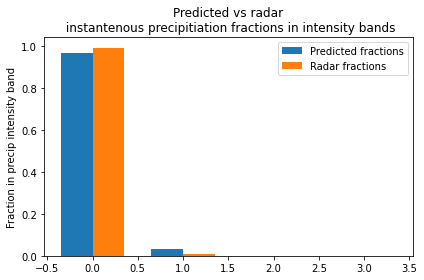

In [ ]:
for loc in np.arange(0,91,18):
    x = np.arange(len(target_parameter))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_pred[loc], width, label='Predicted fractions')
    rects2 = ax.bar(x + width/2, data_splits['y_val'].iloc[loc], width, label='Radar fractions')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction in precip intensity band')
    ax.set_title('Predicted vs radar\n instantenous precipitiation fractions in intensity bands')
    ax.set_xticks(x, target_parameter)
    ax.legend()

    fig.tight_layout()

    plt.show()
    # plt.bar(y_pred[loc], label='prediction')
    # plt.bar(data_splits['y_val'].iloc[loc], label='target')
    # plt.legend()
    # plt.show()

Fractional skill score

In [49]:
# non-cumulative i.e. assessing the FSS of specific bands individually
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,i] - data_splits['y_val'][col])**2
    FBS_ref = y_pred[:,i]**2 + data_splits['y_val'][col]**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.651081294640758
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.6393901033760934
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.5694442009039302
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.22766925394198806
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.0699907323167066


In [ ]:
# cumulative
for i, col in enumerate(target_parameter):
    FBS = (y_pred[:,:i+1].sum(axis=1) - data_splits['y_val'][cols[:i+1]].sum(axis=1))**2
    FBS_ref = y_pred[:,:i+1].sum(axis=1)**2 + data_splits['y_val'][cols[:i+1]].sum(axis=1)**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.7719770967619034
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.9910208042260106
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.9994738389710272
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.9997981705802607


In [51]:
cols

Index(['radar_fraction_in_band_instant_0.0',
       'radar_fraction_in_band_instant_0.25',
       'radar_fraction_in_band_instant_2.5',
       'radar_fraction_in_band_instant_7.0',
       'radar_fraction_in_band_instant_10.0'],
      dtype='object')